In [214]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._previous:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        if n._label:
            dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n._label, n.data, n.gradient), shape='record')
        else:
            dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.gradient), shape='record')
        # dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        if n._operation:
            dot.node(name=str(id(n)) + n._operation, label=n._operation)
            dot.edge(str(id(n)) + n._operation, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)
    
    return dot


In [254]:
import math


class Value:
    def __init__(self,
            data: float,
            children: tuple=(),
            operation: str='',
            label = None,
            ) -> None:
        self.data = data
        self.gradient = 0
        self._backward = lambda: None
        self._previous = set(children)
        self._operation = operation
        self._label = label

    def __repr__(self) -> str:
        return f"Value({round(self.data, 4)})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, children=(self, other), operation='+')
        def _backward():
            # the derivative of a sum is 1 for both terms
            self.gradient += 1.0 * result.gradient
            other.gradient += 1.0 * result.gradient
        result._backward = _backward
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, children=(self, other), operation='*')
        def _backward():
            # the derivative of a product is the other term
            self.gradient += other.data * result.gradient
            other.gradient += self.data * result.gradient
        result._backward = _backward
        return result

    def __exp__(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.gradient += out.data * out.gradient
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        #x**n
        # derivative of x**n is n*x**(n-1)
        other = other if isinstance(other, Value) else Value(other)
        x = self.data
        n = other.data
        result = Value(x**n, children=(self, other), operation='pow')
        def _backward():
            self.gradient += (n * x ** (n - 1)) * result.gradient
            # other.gradient += (x ** n) * math.log(x) * result.gradient
        result._backward = _backward
        return result

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def tanh(self):
        result = Value(
            (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1),
            children=(self,),
            operation='tanh'
        )
        def _backward():
            self.gradient += (1 - result.data ** 2) * result.gradient
        result._backward = _backward
        return result
    
    def relu(self):
        result = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (result.data > 0) * result.grad
        result._backward = _backward
        return result

    def backward(self) -> None:
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._previous:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # go one variable at a time and apply the chain rule to get its gradient
        self.gradient = 1
        for v in reversed(topo):
            v._backward()


a = Value(2)
b = Value(-3)
c = Value(10)
e = a * b
d = e + c
f = Value(-2)
L = d * f
L

Value(-8)

Saying that a function's derivative is taken with respect to another variable means that you are measuring how the function changes as that particular variable changes, while keeping other variables constant if there are any. In calculus, a derivative represents the rate at which a function's value changes as its input changes.

In [216]:
def loss(h):
    a = Value(2 + h)  # changing a a little bit
    b = Value(-3)
    c = Value(10)
    e = a * b
    d = e + c
    f = Value(-2)
    return d * f

h = 0.000001
(loss(h).data - loss(0).data) / h

6.000000000838668

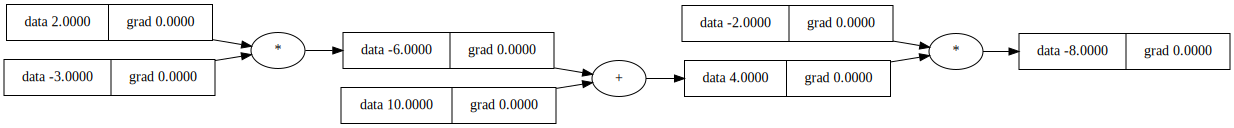

In [217]:
draw_dot(L)

Value(0.6044)


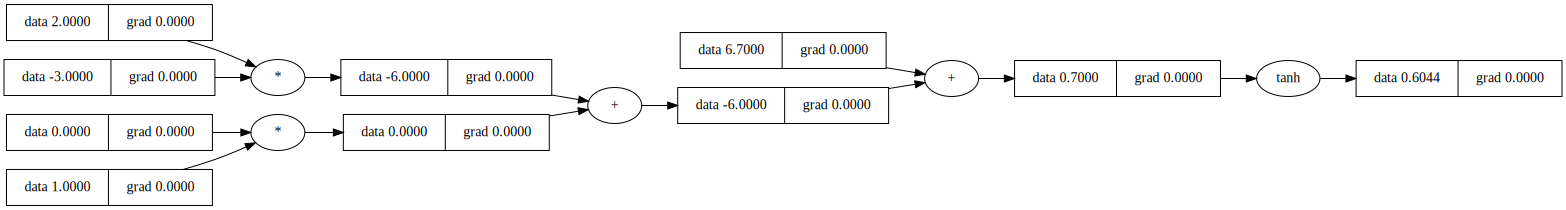

In [218]:
#### 
# EXAMPLE OF ONE NEURON
####
# inputs
x_1 = Value(2)
x_2 = Value(0)
# weights
w_1 = Value(-3)
w_2 = Value(1)
# bias of neuron
b = Value(6.7)

# output
o = (x_1 * w_1 + x_2 * w_2 + b).tanh()  # neuron
print(o)
draw_dot(o)

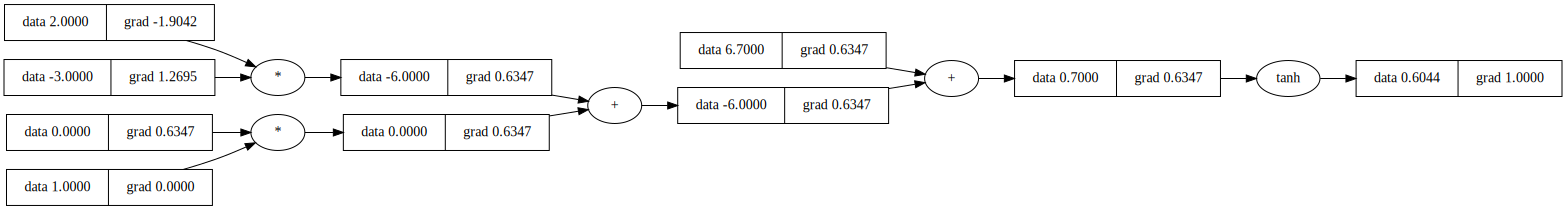

In [219]:
o.backward()
draw_dot(o)

In [220]:
def loss(h):
    # inputs
    x_1 = Value(2)  # data=2; gradient=-1.9042
    x_2 = Value(0)  # data=0; gradient=0.6347
    # weights
    w_1 = Value(-3 + h)  # data=-3; gradient=1.269477
    w_2 = Value(1)
    # bias of neuron
    b = Value(6.7)

    # output
    o = (x_1 * w_1 + x_2 * w_2 + b).tanh()
    return o

h = 0.000001
(loss(h).data - loss(0).data) / h

1.269477645671202

In [221]:
print(w_1.gradient)
print(round(w_1.gradient, 5) == round((loss(h).data - loss(0).data) / h, 5))

1.2694791799649168
True


In [222]:
import torch

x_1 = torch.tensor(2.0, requires_grad=False)
x_2 = torch.tensor(0.0, requires_grad=False)
w_1 = torch.tensor(-3.0, requires_grad=True)
w_2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)

n = x_1*w_1 + x_2*w_2 + b
o = torch.tanh(n)

print(o.data)
o.backward()
print(x_1.grad)
print(x_2.grad)
print(w_1.grad)
print(w_2.grad)
print(b.grad)
print('----')
x_1 = Value(2)
x_2 = Value(0)
w_1 = Value(-3)
w_2 = Value(1)
b = Value(6.8813735870195432)

n = x_1*w_1 + x_2*w_2 + b
o = n.tanh()
print(o)
o.backward()
print(round(x_1.gradient, 4))
print(round(x_2.gradient, 4))
print(round(w_1.gradient, 4))
print(round(w_2.gradient, 4))
print(round(b.gradient, 4))


tensor(0.7071)
None
None
tensor(1.0000)
tensor(0.)
tensor(0.5000)
----
Value(0.7071)
-1.5
0.5
1.0
0.0
0.5


In [271]:
sum([100, 200, 300], 1)

601

In [319]:
import random
from typing import Any

class Neuron:
    def __init__(self, num_inputs: int, layer_name: str | None = None) -> None:
        def _label(index: int) -> str:
            if layer_name:
                return f'{layer_name}_w_{index}'
            else:
                return f'w_{index}'
            
        self.weights = [
            Value(random.uniform(-1, 1), label=_label(index))
            for index in range(num_inputs)
        ]
        bias_label = 'b' if not layer_name else f'{layer_name}___b'
        self.bias = Value(random.uniform(-1, 1), label=bias_label)
    
    def forward(self, inputs: list[Value | int | float]):
        return sum((x * w for x, w in zip(inputs, self.weights, strict=True)),self.bias).tanh()

    def __call__(self, inputs: list[Value | int | float]):
        return self.forward(inputs)

    def parameters(self) -> list[Value]:
        return self.weights + [self.bias]

class Layer:
    def __init__(self, num_inputs: int, num_outputs: int, layer_name: str | None = None) -> None:
        self.neurons = [
            Neuron(num_inputs, layer_name=f"{layer_name}-N{index}")
            for index in range(num_outputs)
        ]
    
    def forward(self, inputs: list[Value | int | float]):
        outputs = [n(inputs) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def __call__(self, inputs: list[Value | int | float]):
        return self.forward(inputs)
    
    def parameters(self) -> list[Value]:
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, num_inputs: int, num_outputs: list[int]) -> None:
        sizes = [num_inputs] + num_outputs
        self.layers = [
            Layer(sizes[i], sizes[i+1], layer_name=f"L{i}")
            for i in range(len(sizes)-1)
        ]
    
    def forward(self, inputs: list[Value | int | float]):
        for layer in self.layers:
            inputs = layer(inputs)
        return inputs

    def __call__(self, inputs: list[Value | int | float]):
        return self.forward(inputs)
    
    def parameters(self) -> list[Value]:
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0]
n = Neuron(len(x))
print(n(x))

l = Layer(len(x), 3)
print(l(x))

mlp = MLP(len(x), [4, 4, 1])
print(mlp(x))

Value(0.9993)
[Value(-0.9218), Value(0.9927), Value(-0.9999)]
Value(-0.0934)


In [320]:
[f"{p._label} | {p.data}" for p in mlp.parameters()]

['L0-N0_w_0 | 0.37540901340442145',
 'L0-N0_w_1 | 0.9569851271620191',
 'L0-N0___b | -0.6792943057598062',
 'L0-N1_w_0 | 0.8262702113650437',
 'L0-N1_w_1 | 0.854554344315922',
 'L0-N1___b | -0.575469034617768',
 'L0-N2_w_0 | 0.16394531448684724',
 'L0-N2_w_1 | 0.44887685351882833',
 'L0-N2___b | 0.33587888591120674',
 'L0-N3_w_0 | -0.17680789946980746',
 'L0-N3_w_1 | -0.8078544190552313',
 'L0-N3___b | 0.8049761568645202',
 'L1-N0_w_0 | 0.16087114752290743',
 'L1-N0_w_1 | -0.5570167493127816',
 'L1-N0_w_2 | -0.25659915009576073',
 'L1-N0_w_3 | -0.7464668647843884',
 'L1-N0___b | 0.22158528683007206',
 'L1-N1_w_0 | 0.061830481673877724',
 'L1-N1_w_1 | -0.48139068168359667',
 'L1-N1_w_2 | 0.49984185703022255',
 'L1-N1_w_3 | -0.9029383955595469',
 'L1-N1___b | -0.8246345925187308',
 'L1-N2_w_0 | -0.4688712366402614',
 'L1-N2_w_1 | 0.716268628856443',
 'L1-N2_w_2 | 0.8339973648451777',
 'L1-N2_w_3 | 0.54519254398511',
 'L1-N2___b | 0.6760046888686448',
 'L1-N3_w_0 | -0.8198603145538046',
 

In [321]:
x

[2.0, 3.0]

In [322]:
for layer in mlp.layers:
    print(f"{len(layer.neurons)} neurons w/ {len(layer.neurons[0].weights)} weights each")

4 neurons w/ 2 weights each
4 neurons w/ 4 weights each
1 neurons w/ 4 weights each


In [323]:
print(len(mlp.layers))
print(len(mlp.layers[0].neurons))
print(mlp.layers[0].neurons[0].weights)
print(mlp.layers[0].neurons[0].bias)

3
4
[Value(0.3754), Value(0.957)]
Value(-0.6793)


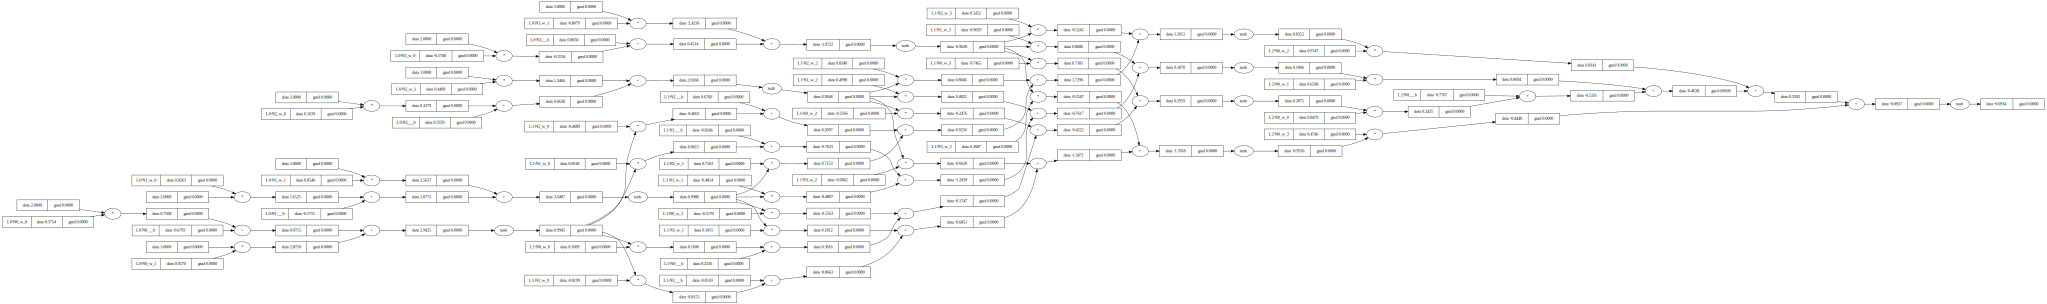

In [324]:
draw_dot(mlp(x))

---

In [325]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
y= [1.0, -1.0, -1.0, 1.0]

num_features = len(X[0])
mlp = MLP(num_features, [4, 4, 1])
predictions = [mlp(x) for x in X]
print(predictions)

[Value(-0.276), Value(0.0023), Value(-0.3431), Value(-0.293)]


In [326]:
#draw_dot(predictions[0])

In [327]:
# loss is a single value that indicates how bad the model is
# we want to minimize the loss
print(y)
print(predictions)
print([(actual - predicted)**2 for actual, predicted in zip(y, predictions)])
loss = sum((actual - predicted)**2 for actual, predicted in zip(y, predictions))
print(loss)

[1.0, -1.0, -1.0, 1.0]
[Value(-0.276), Value(0.0023), Value(-0.3431), Value(-0.293)]
[Value(1.6281), Value(1.0046), Value(0.4316), Value(1.6718)]
Value(4.736)


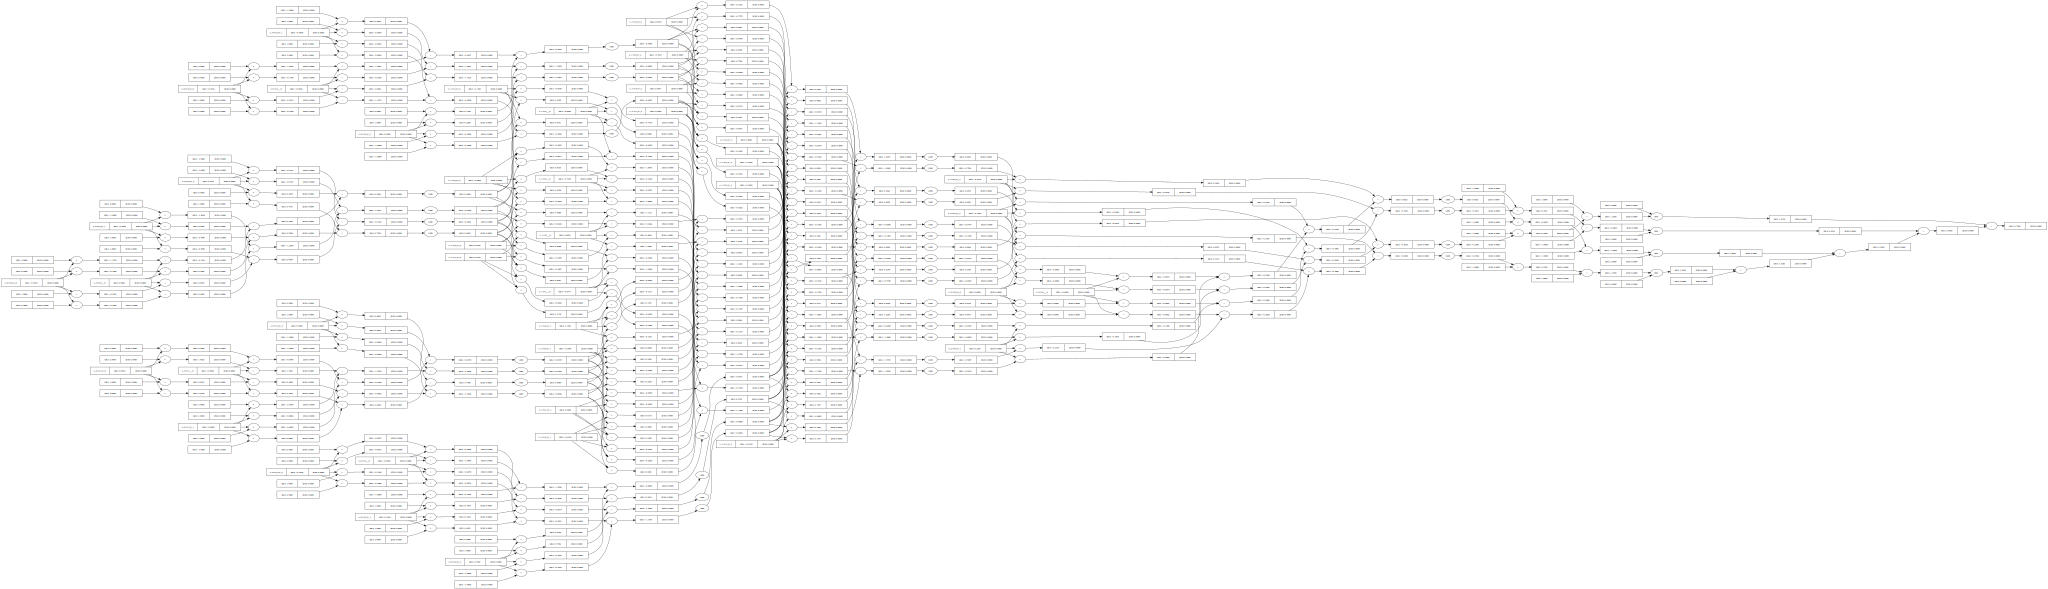

In [328]:
draw_dot(loss)

In [329]:
loss.backward()

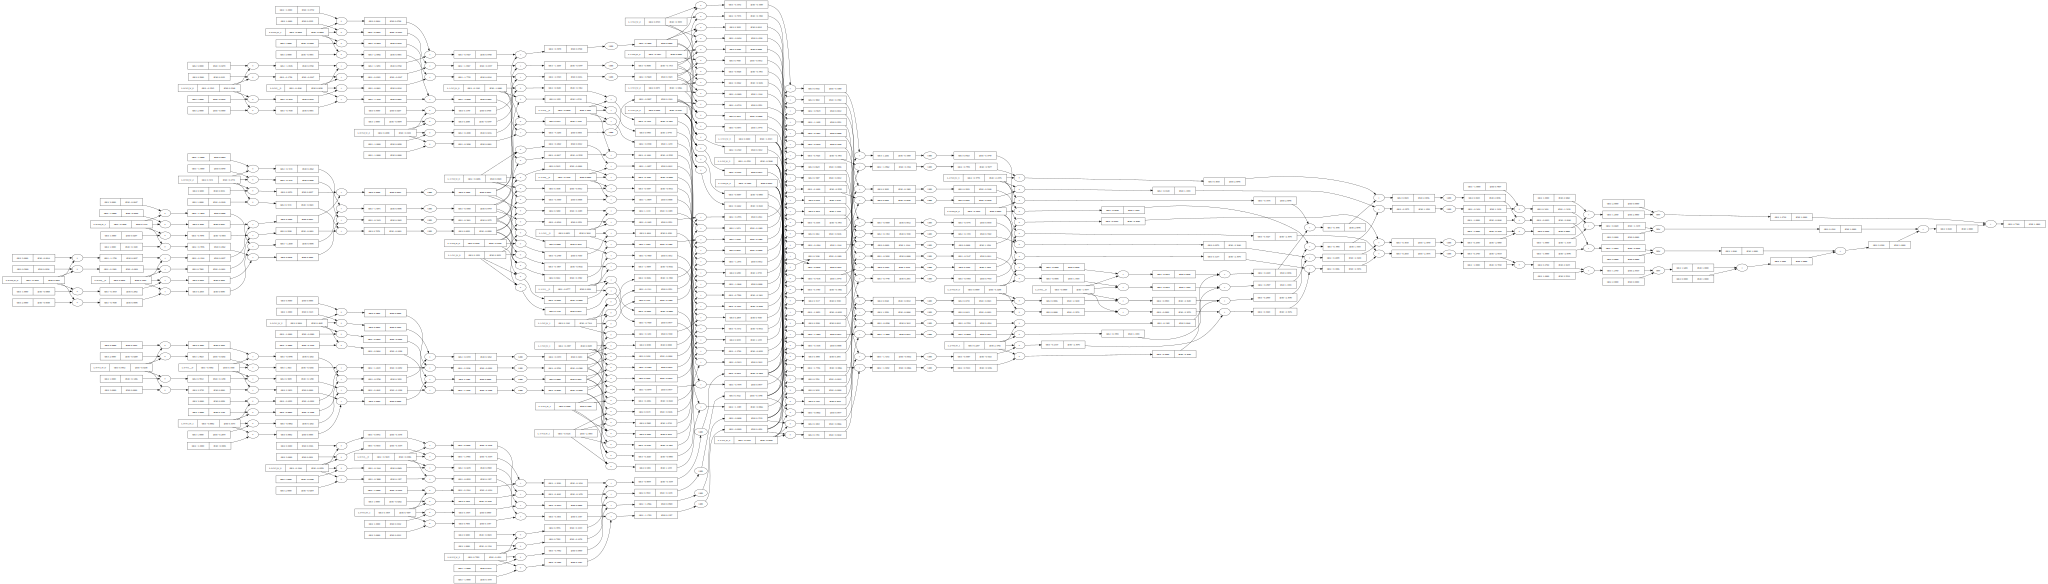

In [330]:
draw_dot(loss)

In [331]:
loss

Value(4.736)

In [345]:
for p in mlp.parameters():
    p.data -= 0.01 * p.gradient

In [346]:
# we have to do a forward pass again because the parameters have changed and so the resulting values and predictions will be different
predictions = [mlp(x) for x in X]
loss = sum((actual - predicted)**2 for actual, predicted in zip(y, predictions))
loss

Value(1.3112)

---

In [423]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
y= [1.0, -1.0, -1.0, 1.0]

num_features = len(X[0])
mlp = MLP(num_features, [4, 4, 1])
predictions = [mlp(x) for x in X]
print(predictions)
loss = sum((actual - predicted)**2 for actual, predicted in zip(y, predictions))
print(loss)

[Value(-0.9452), Value(-0.4512), Value(-0.8515), Value(-0.9154)]
Value(7.7759)


In [467]:
steps = 20
learning_rate = 0.01
# gradient descent
for k in range(steps):
    # forward pass
    predictions = [mlp(x) for x in X]
    loss = sum((actual - predicted)**2 for actual, predicted in zip(y, predictions))
    print(f"step {k}: loss {loss.data} | predictions: {predictions}")
    # backward pass
    for p in mlp.parameters():
        p.gradient = 0
    loss.backward()

    # update parameters
    for p in mlp.parameters():
        p.data -= learning_rate * p.gradient

step 0: loss 0.00604538121802703 | predictions: [Value(0.968), Value(-0.9781), Value(-0.9491), Value(0.9559)]
step 1: loss 0.0060370293084161825 | predictions: [Value(0.968), Value(-0.9781), Value(-0.9491), Value(0.9559)]
step 2: loss 0.006028699411458236 | predictions: [Value(0.9681), Value(-0.9781), Value(-0.9491), Value(0.956)]
step 3: loss 0.006020391441993634 | predictions: [Value(0.9681), Value(-0.9781), Value(-0.9492), Value(0.956)]
step 4: loss 0.006012105315296264 | predictions: [Value(0.9681), Value(-0.9781), Value(-0.9492), Value(0.956)]
step 5: loss 0.006003840947070692 | predictions: [Value(0.9681), Value(-0.9781), Value(-0.9492), Value(0.9561)]
step 6: loss 0.005995598253449587 | predictions: [Value(0.9681), Value(-0.9781), Value(-0.9493), Value(0.9561)]
step 7: loss 0.005987377150990885 | predictions: [Value(0.9682), Value(-0.9782), Value(-0.9493), Value(0.9561)]
step 8: loss 0.005979177556675264 | predictions: [Value(0.9682), Value(-0.9782), Value(-0.9493), Value(0.9561